In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load the data

In [2]:
from trackml.dataset import load_dataset
PATH_TO_DATA = "/home/data/train_sample_single"

In [3]:
data = load_dataset(PATH_TO_DATA, parts=['hits', 'cells', 'truth', 'particles'])
event_id, hits, cells, truth, particles = next(data)

In [4]:
old_keys = truth.keys()
new_truth = truth.merge(hits[['hit_id','volume_id']])
mask = ((new_truth['volume_id']==8) | (new_truth['volume_id']==13) | (new_truth['volume_id']==18))
new_truth = new_truth.loc[mask][old_keys]

<a id='merging'></a>

## Hit merging:


Check for the criteria to merge hits (some of the hits in the layer 1 will originating from the same particle, therefore we will assign same label (`track_id`) to those hits

Lets obtain the distribtion to decide on the cut criteria

In [5]:
def getLayer(r, z, volume_id, layer_id):   
    if volume_id==8 and layer_id==2:
        return 1
    elif volume_id==9:
        return 2
    elif volume_id==7:
        return 2
    else: return -1

In [6]:
hits['r'] = np.sqrt(hits['x']**2 + hits['y']**2)
hits['phi'] = np.arctan2(hits['y'],hits['x'])
hits['theta'] = np.arctan2(hits['r'],hits['z'])
hits['eta'] = -np.log(np.tan(0.5*hits['theta']))
hits['evtid'] = event_id
hits['layer'] = hits.apply(lambda x: getLayer(x['r'],x['z'],x['volume_id'],x['layer_id']), axis=1)
keys = ['hit_id','z','phi','r','layer']
hits = (hits[keys].merge(truth[['hit_id','particle_id']], on='hit_id'))

Sudy the hits from the first layer only (separate barrel with end-caps):

Let's order the hits in increasing order in $\phi$, and look on a neighbour hits.
By construction, these two hits are close in $\phi$, the question which criteria one should apply to verify that these two hits are comming form the same track:

In [7]:
filter_hits = hits.loc[hits['layer']==1]

In [8]:
filtered_sorted_hits = filter_hits.sort_values(by=['phi'])
n = filtered_sorted_hits.shape[0]
dphi = []
dz = []
dr = []
is_true = []
for i in range(n-1):
    is_true.append( filtered_sorted_hits.particle_id.values[i] == filtered_sorted_hits.particle_id.values[i+1]  )
    dphi.append( filtered_sorted_hits.phi.values[i+1] - filtered_sorted_hits.phi.values[i]  ) 
    dz.append( filtered_sorted_hits.z.values[i+1] - filtered_sorted_hits.z.values[i]  ) 
    dr.append( filtered_sorted_hits.r.values[i+1] - filtered_sorted_hits.r.values[i]  ) 
dphi = np.array(dphi)
dz = np.array(dz)
dr = np.array(dr)
is_true = np.array(is_true)

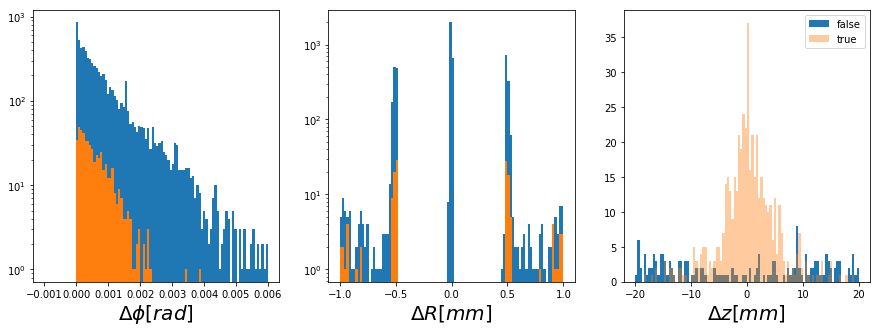

In [9]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.hist(dphi[(is_true==False) ],100,(-0.001,0.006),label='false')
ax.hist(dphi[(is_true==True) ],100,(-0.001,0.006),label='true',log=True)
ax.set_xlabel(r'$\Delta\phi [rad]$',fontsize=20)

ax = fig.add_subplot(1, 3, 2)
ax.hist(dr[(is_true==False) & (dphi<0.002) ],100,(-1,1),label='false')
ax.hist(dr[(is_true==True) & (dphi<0.002) ],100,(-1,1),label='true', log=True)
ax.set_xlabel(r'$\Delta R [mm]$',fontsize=20)

ax = fig.add_subplot(1, 3, 3)
ax.hist(dz[(is_true==False) & (np.fabs(dr)>0.025) & (dphi<0.002)],100,(-20,20),label='false')
ax.hist(dz[(is_true==True) & (np.fabs(dr)>0.025) & (dphi<0.002)],100,(-20,20),label='true',alpha=0.4)
ax.set_xlabel(r'$\Delta z [mm]$',fontsize=20)

plt.legend()
plt.savefig('Merge_hits_Barrel.pdf')
plt.show()   


In [10]:
filter_hits = hits.loc[hits['layer']==2]

In [11]:
filtered_sorted_hits = filter_hits.sort_values(by=['phi'])
n = filtered_sorted_hits.shape[0]
dphi = []
dz = []
dr = []
is_true = []
for i in range(n-1):
    is_true.append( filtered_sorted_hits.particle_id.values[i] == filtered_sorted_hits.particle_id.values[i+1]  )
    dphi.append( filtered_sorted_hits.phi.values[i+1] - filtered_sorted_hits.phi.values[i]  ) 
    dz.append( filtered_sorted_hits.z.values[i+1] - filtered_sorted_hits.z.values[i]  ) 
    dr.append( filtered_sorted_hits.r.values[i+1] - filtered_sorted_hits.r.values[i]  ) 
dphi = np.array(dphi)
dz = np.array(dz)
dr = np.array(dr)
is_true = np.array(is_true)

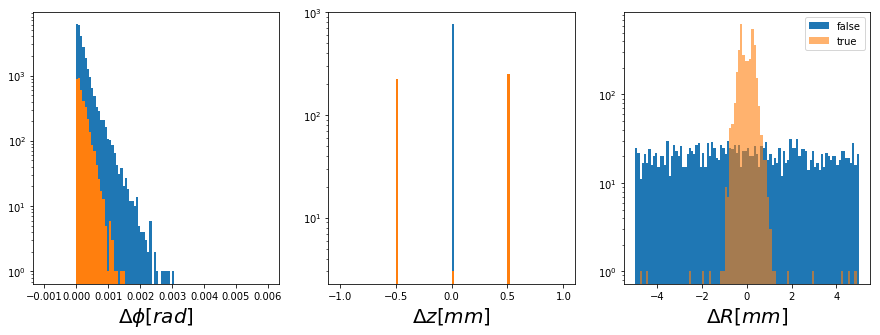

In [12]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.hist(dphi[(is_true==False) ],100,(-0.001,0.006),label='false')
ax.hist(dphi[(is_true==True) ],100,(-0.001,0.006),label='true',log=True)
ax.set_xlabel(r'$\Delta\phi [rad]$',fontsize=20)

ax = fig.add_subplot(1, 3, 2)
ax.hist(dz[(is_true==False) & (dphi<0.001)],100,(-1,1),label='false')
ax.hist(dz[(is_true==True) & (dphi<0.001)],100,(-1,1),label='true', log=True)
ax.set_xlabel(r'$\Delta z [mm]$',fontsize=20)

ax = fig.add_subplot(1, 3, 3)
ax.hist(dr[(is_true==False) & (dphi<0.001) & (np.fabs(dz)>0.25) ],100,(-5,5),label='false')
ax.hist(dr[(is_true==True) & (dphi<0.001) & (np.fabs(dz)>0.25) ],100,(-5,5),label='true',alpha=0.6, log=True)
ax.set_xlabel(r'$\Delta R [mm]$',fontsize=20)


plt.legend()
plt.savefig('Merge_hits_EC.pdf')
plt.show()   
